## Segmengação semântica binária



Montar Drive

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
pip install tensorflow

In [27]:
# Install the python version
!apt-get install python3.7

# Select the version
#!python3.7 setup.py

#Install django
!pip install django

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.7 is already the newest version (3.7.11-1+bionic1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [2]:
!python --version

Python 3.7.11


Importar bibliotecas

In [28]:
import tensorflow
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import django
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from django.apps import apps

Definir diretório imagens e máscaras

In [29]:
#image_directory = '/content/drive/MyDrive/DB_teste_healthy/images/' # 360 testdb
#mask_directory = '/content/drive/MyDrive/DB_teste_healthy/masks/'

image_directory = '/content/drive/MyDrive/DB_patches/h_patches/images' #14280 fulldb
mask_directory = '/content/drive/MyDrive/DB_patches/h_patches/masks'

definir tamanho e número de imagens

In [4]:
SIZE = 256
#num_images = 360 #1 iou 42 # 25 épocas
#num_images = 14280 #2 nao rodou falta RAM
num_images = 1320 #3 iou 62 # 25 épocas
#num_images = 2040 #4 não roda falta RAM
#num_images = 1800 #5 iou não roda falta RAM

Ler imagens

In [5]:
image_dataset = []
#image_names = glob.glob("/content/drive/MyDrive/DB_teste_healthy/images/*.png")
image_names = glob.glob("/content/drive/MyDrive/DB_patches/h_patches/images/*.png")
print(image_names)

image_names.sort() #colocar na ordem
print(image_names)

image_names_subset = image_names[0:num_images] #pegar apenas X imagens, que foi definido na celula acima

images = [cv2.imread(img, 1) for img in image_names_subset]

image_dataset.append(images) # adiciona todas imagens na lista criada
image_dataset = np.array(images)
#image_dataset = np.expand_dims(image_dataset, axis=3)

Output hidden; open in https://colab.research.google.com to view.

Ler máscaras

In [6]:
mask_dataset = []
#mask_names = glob.glob("/content/drive/MyDrive/DB_teste_healthy/masks/*.png")
mask_names = glob.glob("/content/drive/MyDrive/DB_patches/h_patches/masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset] #tentar ler com cor
mask_dataset.append(masks) # adiciona todas imagens na lista criada
mask_dataset = np.array(masks)
#mask_dataset = np.expand_dims(mask_dataset, axis=3)

Checkpoint

In [9]:
print ("Image data shape:", image_dataset.shape)
print ("Mask data shape:", mask_dataset.shape)
print ("Max pixel valeue in image:", image_dataset.max())
print ("Labels in masks:", np.unique(mask_dataset))

Image data shape: (1800, 256, 256, 3)
Mask data shape: (1800, 256, 256)
Max pixel valeue in image: 255
Labels in masks: [ 0 38]


Reencodar legendas

In [7]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder() # só funciona em vetor unico e temos 3 dimensoes, com isso faz reshape no vetor
n, h, w = mask_dataset.shape # separar dimensões do formato da mascara #numero de bandas, altura e largura
mask_dataset = mask_dataset.reshape(-1,1) # reshape para? (para normalizar)
mask_dataset = labelencoder.fit_transform(mask_dataset) # transformar e adequar, reencoda tudo
mask_dataset = mask_dataset.reshape(n, h, w) # 

np.unique(mask_dataset) # mostrar legendas das mascaras
mask_dataset = np.expand_dims(mask_dataset, axis=3)
print (np.unique(mask_dataset))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1]


Normalize Images

In [8]:
image_dataset = image_dataset/255 #mesma coisa do minmaxscaler
#print (np.unique(image_dataset))

# não normalizar mascaras, apenas rescale to 0 to 1.
#mask_dataset = mask_dataset/255 #valores de pixel entre 0 e 1

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1]


Checagem, ver algumas imagens

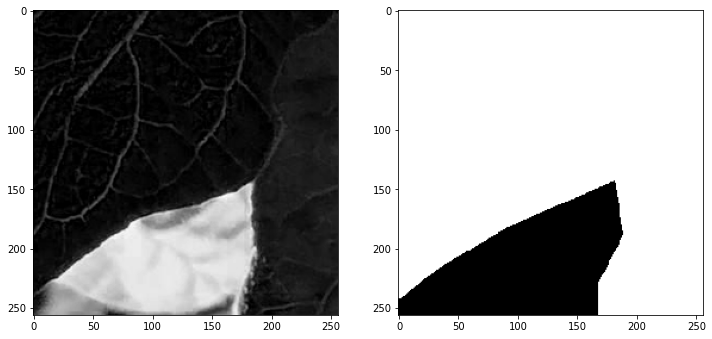

In [21]:
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:,0],cmap='gray') #como colocar rgb?
plt.subplot(122)
plt.imshow(y_train[image_number, :,:,0],cmap='gray')
plt.show()

Construir modelo UNET dividindo os encoders e decoders em blocos


In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

def conv_block (input,num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x) #not in the original network
    x = Activation("relu")(x)
        
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x) #not in the original network
    x = Activation("relu")(x)
        
    return x

    #encoder block: conv block followed by maxpooling
    
def encoder_block (input,num_filters):
    x = conv_block(input,num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p
    
#Decoder block
#skip features gets input from encoder for cocatenation

def decoder_block(input,skip_features,num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#build UNET using the blocks
def build_unet(input_shape, n_classes):
    inputs= Input(input_shape)
    
    s1,p1 = encoder_block(inputs,64)
    s2,p2 = encoder_block(p1,128)
    s3,p3 = encoder_block(p2,256)
    s4,p4 = encoder_block(p3,512)
    
    b1 = conv_block(p4,1024) #ponte
    
    d1 = decoder_block(b1,s4,512)
    d2 = decoder_block(d1,s3,256)
    d3 = decoder_block(d2,s2,128)
    d4 = decoder_block(d3,s1,64)

    if n_classes == 1: #binary
        activation = "sigmoid" 
    else:
        activation = "softmax"
        
    outputs = Conv2D(n_classes, 1,padding="same", activation=activation)(d4) #change the activation based on n_classes
    print(activation)
    
    model = Model(inputs,outputs, name="U-Net")
    return model


Entradas

In [11]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]
    
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [24]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________

In [25]:

history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=25,
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/25
90/90 [==============================] - 147s 928ms/step - loss: 0.4842 - accuracy: 0.7663 - val_loss: 2.3749 - val_accuracy: 0.7665
Epoch 2/25
90/90 [==============================] - 80s 894ms/step - loss: 0.4030 - accuracy: 0.8101 - val_loss: 0.5459 - val_accuracy: 0.7682
Epoch 3/25
90/90 [==============================] - 81s 896ms/step - loss: 0.4013 - accuracy: 0.8125 - val_loss: 0.9919 - val_accuracy: 0.4108
Epoch 4/25
90/90 [==============================] - 80s 894ms/step - loss: 0.3957 - accuracy: 0.8103 - val_loss: 0.4732 - val_accuracy: 0.7672
Epoch 5/25
90/90 [==============================] - 80s 894ms/step - loss: 0.3923 - accuracy: 0.8140 - val_loss: 0.4304 - val_accuracy: 0.7681
Epoch 6/25
90/90 [==============================] - 80s 894ms/step - loss: 0.3881 - accuracy: 0.8154 - val_loss: 0.4427 - val_accuracy: 0.7674
Epoch 7/25
90/90 [==============================] - 81s 898ms/step - loss: 0.3913 - accuracy: 0.8131 - val_loss: 0.4240 - val_accuracy: 0.774

Salvar modelo

In [26]:
model.save('/content/drive/MyDrive/DB_teste_healthy/binary_1_8kDB.hdf5')

Ler pesos _caso rode modelo salvo depois para pegar resultados..

In [23]:
#model = get_model()
#filenew_model = keras.models.load_model('/content/drive/MyDrive/DB_teste_healthy/binary_1_8kDB.hdf5')
#model.load_weights('/content/drive/MyDrive/DB_teste_healthy/binary_1_8kDB.hdf5')  

#from django.apps import apps

#apps.get_model('/content/drive/MyDrive/DB_teste_healthy/binary_1_8kDB.hdf5')


#from django.apps import apps
#model = apps.get_model('/content/drive/MyDrive/DB_teste_healthy/binary_1_8kDB.hdf5', "model")
#print (model)


AppRegistryNotReady: ignored

Plotar acurácia de treinamento e validação e perda em cada época

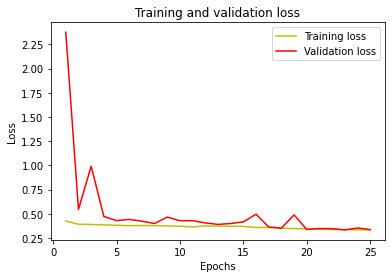

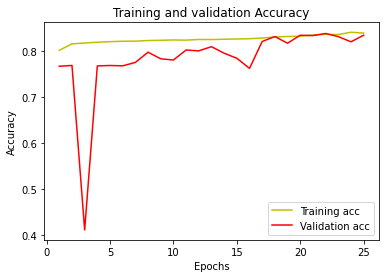

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


IOU

In [24]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5 # 0.5 sigmoid da probabildiade entre 0 e 1, por isso 0.5 para converter a probabilidade em classes, com o threshold

NameError: ignored

In [ ]:
from keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test) # 
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.6278373


(1, 256, 256, 3)
(256, 256)


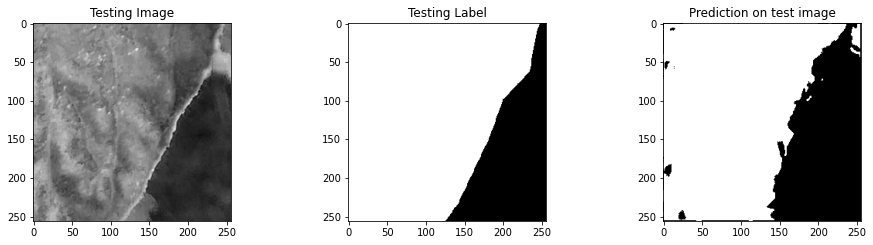

In [ ]:
threshold = 0.5 #0.5
test_img_number = random.randint(0, len(X_test)-1) #len(X_train ou X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0) 
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0]>0.5).astype(np.uint8) #
print(prediction.shape)

# Plotar resultados
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()
